In [1]:
import pyvista as pv
pv.start_xvfb(wait=0)
pv.set_jupyter_backend('html')

import os
import sys
sys.path.append(os.path.join('..', '.'))

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

from pytorch3d.structures import Meshes
from pytorch3d.io import load_objs_as_meshes, save_obj
from pytorch3d.ops import cubify, cot_laplacian, sample_points_from_meshes, knn_points, knn_gather, norm_laplacian, taubin_smoothing
from pytorch3d.loss import chamfer_distance
from pytorch3d.utils import ico_sphere

from torch_geometric.utils import degree, to_undirected, to_dense_adj, get_laplacian, add_self_loops
from torch_geometric.data import Data
# from torch_geometric.transforms import gdc
from torch_scatter import scatter

import numpy as np

import trimesh


from scipy.sparse.linalg import eigsh
from scipy.sparse import coo_matrix


from data_process.dataset_real_scaling import UKBB_dataset, MMWHS_dataset, ACDC_dataset, CCT48_dataset
from ops.graph_operators import NativeFeaturePropagation, LaplacianSmoothing


from tqdm import tqdm

from probreg import cpd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from pytorch3d.transforms import axis_angle_to_matrix, matrix_to_axis_angle


import warnings
warnings.filterwarnings("ignore")

from GHD import GHD_config, GHDmesh, Normal_iterative_GHDmesh
from GHD.GHD_cardiac import GHD_Cardiac


from data_process.dataset_real_scaling import UKBB_dataset, MMWHS_dataset, ACDC_dataset, CCT48_dataset

from einops import rearrange, einsum, repeat

from pytorch3d.loss import chamfer_distance,mesh_laplacian_smoothing, mesh_normal_consistency, mesh_edge_loss


from losses import *
from ops.mesh_geometry import *

import pickle


/home/yihao/anaconda3/envs/medicalimage/lib/python3.9/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /home/yihao/anaconda3/envs/medicalimage/lib/python3.9/site-packages/libpyg.so: undefined symbol: _ZN3c109TupleTypeC1ESt6vectorINS_4Type24SingletonOrSharedTypePtrIS2_EESaIS4_EESt8optionalINS_13QualifiedNameEESt10shared_ptrINS_14FunctionSchemaEE
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/home/yihao/anaconda3/envs/medicalimage/lib/python3.9/site-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /home/yihao/anaconda3/envs/medicalimage/lib/python3.9/site-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/home/yihao/anaconda3/envs/medicalimage/lib/python3.9/site-packages/torch_geome

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
base_shape_path = '../canonical_shapes/Standard_LV_2000.obj'
bi_ventricle_path = '../canonical_shapes/Standard_BiV.obj'

# base_shape_path = 'metadata/Standard_LV.obj'
# bi_ventricle_path = 'metadata/Standard_BiV.obj'

cfg = GHD_config(base_shape_path=base_shape_path,
            num_basis=7**2, mix_laplacian_tradeoff={'cotlap':1.0, 'dislap':0.1, 'stdlap':0.1},
            device='cuda:3',
            if_nomalize=True, if_return_scipy=True, 
            bi_ventricle_path=bi_ventricle_path)

paraheart = GHD_Cardiac(cfg) # 


# load initial orientation according to dataset

with open('../canonical_shapes/mmwhs_init_affine.pkl', 'rb') as f:
    initial_orientation = pickle.load(f)

R = initial_orientation[:3,:3].astype(np.float32)
T = initial_orientation[:3,3].astype(np.float32)

paraheart.R = matrix_to_axis_angle(torch.from_numpy(R).to(paraheart.device)).view(paraheart.R.shape)
paraheart.T = torch.from_numpy(T).to(paraheart.device).view(paraheart.T.shape)

GHD config:
base_shape_path ../canonical_shapes/Standard_LV_2000.obj
num_basis 49
device cuda:3
mix_laplacian_tradeoff {'cotlap': 1.0, 'dislap': 0.1, 'stdlap': 0.1}
if_lap_nomalize True
eign_path None
if_nomalize True
if_return_scipy True
bi_ventricle_path ../canonical_shapes/Standard_BiV.obj


In [3]:
root_path = os.path.dirname(os.path.realpath('..'))

root_path = os.path.join(root_path,'Dataset','MMWHS')

mmwhs_bi_lv = MMWHS_dataset(output_size=(128, 128, 128),dataset_path=root_path,
                            if_augment=False, label_value_list=[[205.,600.],[205.]],eps= 0.01, process_device=paraheart.device)


In [4]:
dataloader_mmwhs = DataLoader(mmwhs_bi_lv, batch_size=1, shuffle=False)

LaplacianSmoother = LaplacianSmoothing()

for i, data in enumerate(dataloader_mmwhs):
    if i<1:
        continue
    # if i not in [15]:
    #     continue
    print(str(i))
    # img = data['img'].to(device)
    seg_gt = data['seg_gt']

    seg_gt_bi = seg_gt[:,0,...].to(paraheart.device).float()
    seg_gt_lv = seg_gt[:,1,...].to(paraheart.device).float()


    window_size = data['window_size'].to(paraheart.device).float()

    mesh_gt_lv = cubify(seg_gt_lv, 0.5)
    mesh_gt_lv = mesh_gt_lv.update_padded((mesh_gt_lv.verts_padded()*window_size/200).float())
    # mesh_gt_lv = LaplacianSmoother.mesh_smooth(mesh_gt_lv, num_iterations=1)
    mesh_gt_lv = taubin_smoothing(mesh_gt_lv, 0.1, 0.5, num_iter=20)
    


    mesh_gt_bi = cubify(seg_gt_bi, 0.5)
    mesh_gt_bi = mesh_gt_bi.update_padded((mesh_gt_bi.verts_padded()*window_size/200).float())
    # mesh_gt_bi = LaplacianSmoother.mesh_smooth(mesh_gt_bi, num_iterations=1)
    mesh_gt_bi = taubin_smoothing(mesh_gt_bi, 0.1, 0.5, num_iter=20)

    bbox_lv = mesh_gt_lv.get_bounding_boxes()[0]*1.3
    # point cloud from the mask
    # bi-ventricle
    points_bi = torch.stack(torch.where(seg_gt_bi>0.5)[1:], dim=-1).float()
    points_bi = points_bi/(torch.tensor(seg_gt_bi.shape[-3:]).float().to(paraheart.device)-1)*2-1
    points_bi = points_bi[:,[2,1,0]]*window_size/200

    # left ventricle
    points_lv = torch.stack(torch.where(seg_gt_lv>0.5)[1:], dim=-1).float()
    points_lv = points_lv/(torch.tensor(seg_gt_lv.shape[-3:]).float().to(paraheart.device)-1)*2-1
    points_lv = points_lv[:,[2,1,0]]*window_size/200 

    # out of the LV
    points_outoflv = torch.stack(torch.where(seg_gt_lv<0.5)[1:], dim=-1).float()
    points_outoflv = points_outoflv/(torch.tensor(seg_gt_lv.shape[-3:]).float().to(paraheart.device)-1)*2-1
    points_outoflv = points_outoflv[:,[2,1,0]]*window_size/200

    points_outoflv_in_bbox = points_outoflv[(points_outoflv[:,0]>bbox_lv[0,0]) & (points_outoflv[:,0]<bbox_lv[0,1]) & (points_outoflv[:,1]>bbox_lv[1,0]) & (points_outoflv[:,1]<bbox_lv[1,1]) & (points_outoflv[:,2]>bbox_lv[2,0]) & (points_outoflv[:,2]<bbox_lv[2,1])]


    break

FileNotFoundError: No such file or no access: '/home/yihao/Document/Dataset/MMWHSct_train/ct_train_1001_image.nii.gz'

In [7]:
sample_num = 2000

mesh_gt_bi_sample = points_bi.detach().cpu().numpy()[np.random.choice(points_bi.shape[0], sample_num, replace=False)]
paraheart.global_registration_biv(mesh_gt_bi_sample)


sample_lv = points_lv[np.random.choice(points_lv.shape[0], sample_num, replace=False)]
paraheart.global_registration_lv(sample_lv.detach().cpu().numpy())

{'rot': array([[-0.92773225,  0.07023383,  0.36657889],
        [-0.16443224,  0.80478654, -0.57033381],
        [-0.33507448, -0.58939446, -0.73507773]]),
 'scale': 0.8472235568789968,
 't': array([0.05848228, 0.19792948, 0.45499714])}

In [8]:
pl = pv.Plotter(notebook=True)
trimesh_gt_lv = trimesh.Trimesh(mesh_gt_lv.verts_packed().detach().cpu().numpy(), mesh_gt_lv.faces_packed().detach().cpu().numpy())
trimesh_gt_lv = pv.wrap(trimesh_gt_lv)
pl.add_mesh(trimesh_gt_lv, color='lightgreen', opacity=0.5)

# trimesh_gt_bi = trimesh.Trimesh(mesh_gt_bi.verts_packed().detach().cpu().numpy(), mesh_gt_bi.faces_packed().detach().cpu().numpy())
# trimesh_gt_bi = pv.wrap(trimesh_gt_bi)
# pl.add_mesh(trimesh_gt_bi, color='green', opacity=0.2)


out_ghd_mesh = paraheart.rendering()

# trimesh_current_bi = paraheart.rendering_bi_ventricle()
# trimesh_current_bi = pv.wrap(trimesh_current_bi)
# pl.add_mesh(trimesh_current_bi, color='blue', opacity=0.2)


trimesh_current_lv = trimesh.Trimesh(out_ghd_mesh.verts_packed().detach().cpu().numpy(), out_ghd_mesh.faces_packed().detach().cpu().numpy())
trimesh_current_lv = pv.wrap(trimesh_current_lv)
pl.add_mesh(trimesh_current_lv, color='lightblue', opacity=0.5)

# pl.add_points(points_bi.detach().cpu().numpy(), color='red', point_size=5)
pl.add_points(points_lv.detach().cpu().numpy(), color='yellow', point_size=5)
pl.show()


EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

In [9]:

# sample_outoflv = points_outoflv_in_bbox[np.random.choice(points_outoflv_in_bbox.shape[0], sample_num*5, replace=False)]

convergence, Loss_dict_list  = paraheart.morphing2lvtarget(points_lv, points_outoflv_in_bbox, target_mesh=mesh_gt_lv, loss_dict 
                            = {'Loss_occupancy':1, 'Loss_normal_consistency':0.01, 'Loss_Laplacian':0.02, 'Loss_equaledge':0.01, 'Loss_rigid':0.1}, 
                            lr_start=1e-4, num_iter=2000, if_reset=True, if_fit_R=False, if_fit_s=True, if_fit_T=True, record_convergence=True)

Total Loss: 0.0000:   0%|          | 0/2000 [00:00<?, ?it/s]

Total Loss: 0.0440: 100%|██████████| 2000/2000 [00:33<00:00, 59.80it/s]

fittings done, the final loss is 0.045065


In [24]:
pl = pv.Plotter(notebook=True)

out_ghd_mesh = paraheart.rendering()

trimesh_current_lv = trimesh.Trimesh(out_ghd_mesh.verts_packed().detach().cpu().numpy(), out_ghd_mesh.faces_packed().detach().cpu().numpy())
trimesh_current_lv = pv.wrap(trimesh_current_lv)

pl.add_mesh(trimesh_current_lv, color='lightblue', opacity=0.5)
pl.add_points(points_lv.detach().cpu().numpy(), color='yellow', point_size=5)
pl.show()

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

In [9]:
from losses import  Mesh_loss

In [9]:

paraheart.s = paraheart.s.detach()*0.85

paraheart.reset_GHD_param()

Mesh_initial = paraheart.rendering().detach().clone()

deform_verts = torch.full(Mesh_initial.verts_packed().shape, 0.0, device=paraheart.device, requires_grad=True)
deform_verts_2 = torch.full(Mesh_initial.verts_packed().shape, 0.0, device=paraheart.device, requires_grad=True)
# deform_verts.requires_grad = True
s_coord = torch.full((1,1), 1.0, device=paraheart.device, requires_grad=True)
T_coord = torch.full((1,3), 0.0, device=paraheart.device, requires_grad=True)
lr = 1e-4
optimizer_GHB = optim.AdamW([paraheart.GHD_param], lr=lr)
optimizer_coordinate = optim.AdamW([deform_verts], lr=lr)

optimizer_coordinate_2 = optim.AdamW([deform_verts_2], lr=lr)


# Number of optimization steps
Niter = 20000
# Weight for the chamfer loss
loss_dict = {'loss_p0': 1., 'loss_n1': 1, 'loss_laplacian': 0.1}
loss_dict_2 = {'loss_p0': 1., 'loss_laplacian': 5., 'loss_n1': 1}
# loss_dict = {'loss_p0': 1, 'loss_n1': 0.2}
# plot period for visualization
plot_period = 500

loop = tqdm(range(Niter))

chamfer_losses_coord = []
chamfer_losses_ghb = []
chamfer_losses_coord_2 = []

total_loss_coord = []
total_loss_ghb = []
total_loss_coord_2 = []

good_angle_ratio_ghb = []
good_angle_ratio_coord = []
good_angle_ratio_coord_2 = []

mesh_losser = Mesh_loss(Mesh_initial.detach().clone())


device = paraheart.device


for i in loop:

    
    # Deform the mesh
    
    current_mesh_coord = Mesh_initial.offset_verts(deform_verts)

    current_mesh_coord_2 = Mesh_initial.offset_verts(deform_verts_2)
    
    current_mesh_ghb = paraheart.rendering()


    
    # Weighted sum of the losses
    loss_mesh_coord = mesh_losser.forward(current_mesh_coord, mesh_gt_lv, loss_dict)
    loss_mesh_ghb = mesh_losser.forward(current_mesh_ghb, mesh_gt_lv, loss_dict)
    loss_mesh_coord_2 = mesh_losser.forward(current_mesh_coord_2, mesh_gt_lv, loss_dict_2)

    loss_coord = 0.
    evaluation_coord = 0.
    for key, value in loss_mesh_coord.items():
        if key != 'loss_n1':
            loss_coord += value*loss_dict[key]
        if key == 'loss_p0' or key == 'loss_n1':
            evaluation_coord += value


    loss_ghb = 0.
    evaluation_ghb = 0.
    for key, value in loss_mesh_ghb.items():
        if key != 'loss_n1':
            loss_ghb += value*loss_dict[key]
        if key == 'loss_p0' or key == 'loss_n1':
            evaluation_ghb += value
    

    loss_coord_2 = 0.
    evaluation_coord_2 = 0.
    for key, value in loss_mesh_coord_2.items():
        if key != 'loss_n1':
            loss_coord_2 += value*loss_dict_2[key]
        if key == 'loss_p0' or key == 'loss_n1':
            evaluation_coord_2 += value
    
    # Print the losses
    loop.set_description('chamfer_loss_coord = %.4f' % loss_coord + '      total_loss_ghb = %.4f' % loss_ghb)

    
    # Save the losses for plotting
    chamfer_losses_coord.append(evaluation_coord.item())
    total_loss_coord.append(loss_coord.item())


    chamfer_losses_ghb.append(evaluation_ghb.item())
    total_loss_ghb.append(loss_ghb.item())

    chamfer_losses_coord_2.append(evaluation_coord_2.item())
    total_loss_coord_2.append(loss_coord_2.item())

    angle_array = (faces_angle(current_mesh_ghb)/np.pi*180).flatten().detach().cpu().numpy()
    good_angle_ratio_ghb.append(np.sum((angle_array>30)*(angle_array<120))/angle_array.shape[0])

    angle_array = (faces_angle(current_mesh_coord)/np.pi*180).flatten().detach().cpu().numpy()
    good_angle_ratio_coord.append(np.sum((angle_array>30)*(angle_array<120))/angle_array.shape[0])

    angle_array = (faces_angle(current_mesh_coord_2)/np.pi*180).flatten().detach().cpu().numpy()
    good_angle_ratio_coord_2.append(np.sum((angle_array>30)*(angle_array<120))/angle_array.shape[0])
    
    # Plot mesh
    if i % plot_period == 0 or i == Niter - 1:
        pl = pv.Plotter(shape=(1, 3), window_size=[1200, 400], off_screen=True)
        pl.subplot(0, 1)
        trimesh_gt_lv = trimesh.Trimesh(mesh_gt_lv.verts_packed().detach().cpu().numpy(), mesh_gt_lv.faces_packed().detach().cpu().numpy())
        pl.add_mesh(trimesh_gt_lv, color='lightgreen', opacity=0.1)
        pl.camera.zoom = 0.01
        pl.camera.roll = 120
        trimesh_current_lv = trimesh.Trimesh(current_mesh_coord.verts_packed().detach().cpu().numpy(), current_mesh_ghb.faces_packed().detach().cpu().numpy())
        pl.add_mesh(trimesh_current_lv, color='lightblue', opacity=0.5, show_edges=True, edge_color='darkblue')

        pl.subplot(0, 0)
        pl.add_mesh(trimesh_gt_lv, color='lightgreen', opacity=0.1)
        trimesh_current_lv = trimesh.Trimesh(current_mesh_ghb.verts_packed().detach().cpu().numpy(), current_mesh_coord.faces_packed().detach().cpu().numpy())
        pl.add_mesh(trimesh_current_lv, color='orange', opacity=0.5, show_edges=True, edge_color='salmon')
        pl.camera.roll = 120

        pl.subplot(0, 2)
        pl.add_mesh(trimesh_gt_lv, color='lightgreen', opacity=0.1)
        trimesh_current_lv = trimesh.Trimesh(current_mesh_coord_2.verts_packed().detach().cpu().numpy(), current_mesh_coord_2.faces_packed().detach().cpu().numpy())
        pl.add_mesh(trimesh_current_lv, color='blue', opacity=0.5, show_edges=True, edge_color='darkblue')
        pl.camera.roll = 120

        pl.screenshot('convergence_data/iter_%d.png'%i, window_size=[800, 400])
        pl.close()

        
    # Optimization step
    loss_coord.backward()
    optimizer_coordinate.step()
    optimizer_coordinate.zero_grad()

    
    loss_ghb.backward()
    optimizer_GHB.step()
    optimizer_GHB.zero_grad()

    loss_coord_2.backward()
    optimizer_coordinate_2.step()
    optimizer_coordinate_2.zero_grad()
    
    if i % 5000 == 0:
        # save the losses for plotting
        np.save('convergence_data/chamfer_losses_coord_sgd.npy', np.array(chamfer_losses_coord))
        np.save('convergence_data/total_loss_coord_sgd.npy', np.array(total_loss_coord))
        np.save('convergence_data/chamfer_losses_ghb_sgd.npy', np.array(chamfer_losses_ghb))
        np.save('convergence_data/total_loss_ghb_sgd.npy', np.array(total_loss_ghb))

        # save the mesh
    if i % 1000 == 0:
        save_obj("convergence_data/mesh_out_ghb.obj", current_mesh_ghb.verts_packed(), current_mesh_ghb.faces_packed())
        save_obj("convergence_data/mesh_out_coord.obj", current_mesh_coord.verts_packed(), current_mesh_coord.faces_packed())

  0%|          | 0/20000 [00:00<?, ?it/s]

chamfer_loss_coord = 0.0057      total_loss_ghb = 0.0057:   0%|          | 0/20000 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/home/yihao/Document/GHDHeart/Demo/convergence_data/iter_0.png'

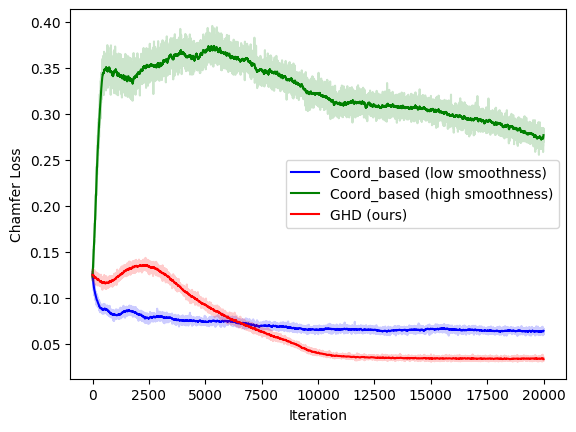

In [ ]:
# plt.plot(total_loss_coord, label='chamfer_losses_coord', color='blue')
# plt.plot(total_loss_coord_2, label='chamfer_losses_coord_2', color='green')
# plt.plot(total_loss_ghb, label='chamfer_losses_ghb', color='red')

import scipy

plt.plot(chamfer_losses_coord,color='blue', alpha=0.2)
# smoothen the curve
chamfer_losses_coord_smooth = scipy.signal.savgol_filter(chamfer_losses_coord, 101, 3)
plt.plot(chamfer_losses_coord_smooth, label='Coord_based (low smoothness)', color='blue')

plt.plot(chamfer_losses_coord_2, color='green', alpha=0.2)
chamfer_losses_coord_2_smooth = scipy.signal.savgol_filter(chamfer_losses_coord_2, 101, 3)
plt.plot(chamfer_losses_coord_2_smooth, label='Coord_based (high smoothness)', color='green')



plt.plot(chamfer_losses_ghb, color='red', alpha=0.2)
chamfer_losses_ghb_smooth = scipy.signal.savgol_filter(chamfer_losses_ghb, 101, 3)
plt.plot(chamfer_losses_ghb_smooth, label='GHD (ours)', color='red')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Chamfer Loss')
# ---red: GHB, blue: coord, green: coord_2
plt.show()


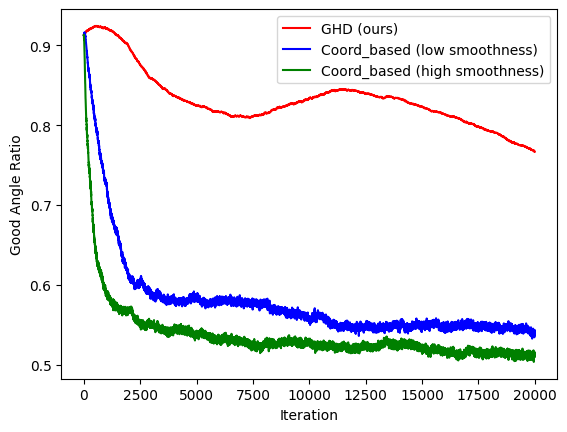

In [ ]:
plt.plot(good_angle_ratio_ghb, label='GHD (ours)', color='red')
plt.plot(good_angle_ratio_coord, label='Coord_based (low smoothness)', color='blue')
plt.plot(good_angle_ratio_coord_2, label='Coord_based (high smoothness)', color='green')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Good Angle Ratio')
plt.show()

In [ ]:

# pl.show(screenshot='convergence_data/ghb_coord.png', window_size=[800, 400], auto_close=True, off_screen=True)



0.9128333333333334


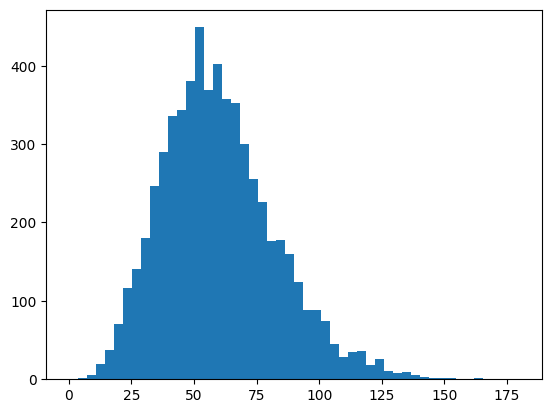

In [ ]:
## histgram of the angle between faces


angle_array = (faces_angle(Mesh_initial)/np.pi*180).flatten().detach().cpu().numpy()
plt.hist(angle_array, bins=50, range=(0,180))
good_angle_ratio = np.sum((angle_array>30)*(angle_array<120))/angle_array.shape[0]
print(good_angle_ratio)
plt.show()

0.7668333333333334


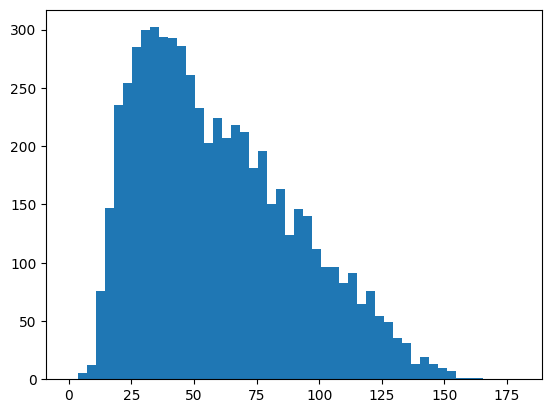

In [ ]:
angle_array = (faces_angle(current_mesh_ghb)/np.pi*180).flatten().detach().cpu().numpy()
# np.histogram(angle_array, bins=100)
plt.hist(angle_array, bins=50, range=(0,180))
good_angle_ratio = np.sum((angle_array>30)*(angle_array<120))/angle_array.shape[0]
print(good_angle_ratio)
plt.show()

0.5405


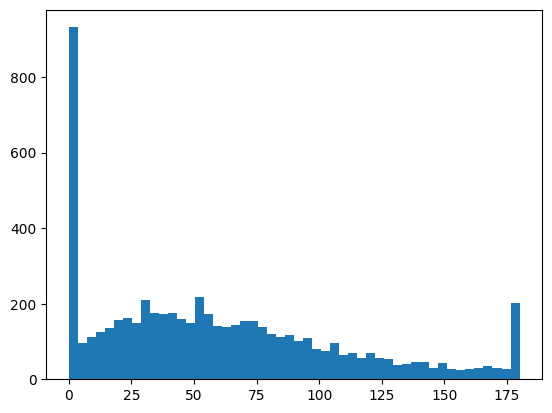

In [ ]:
angle_array = (faces_angle(current_mesh_coord)/np.pi*180).flatten().detach().cpu().numpy()
plt.hist(angle_array, bins=50, range=(0,180))
good_angle_ratio = np.sum((angle_array>30)*(angle_array<120))/angle_array.shape[0]
print(good_angle_ratio)
plt.show()

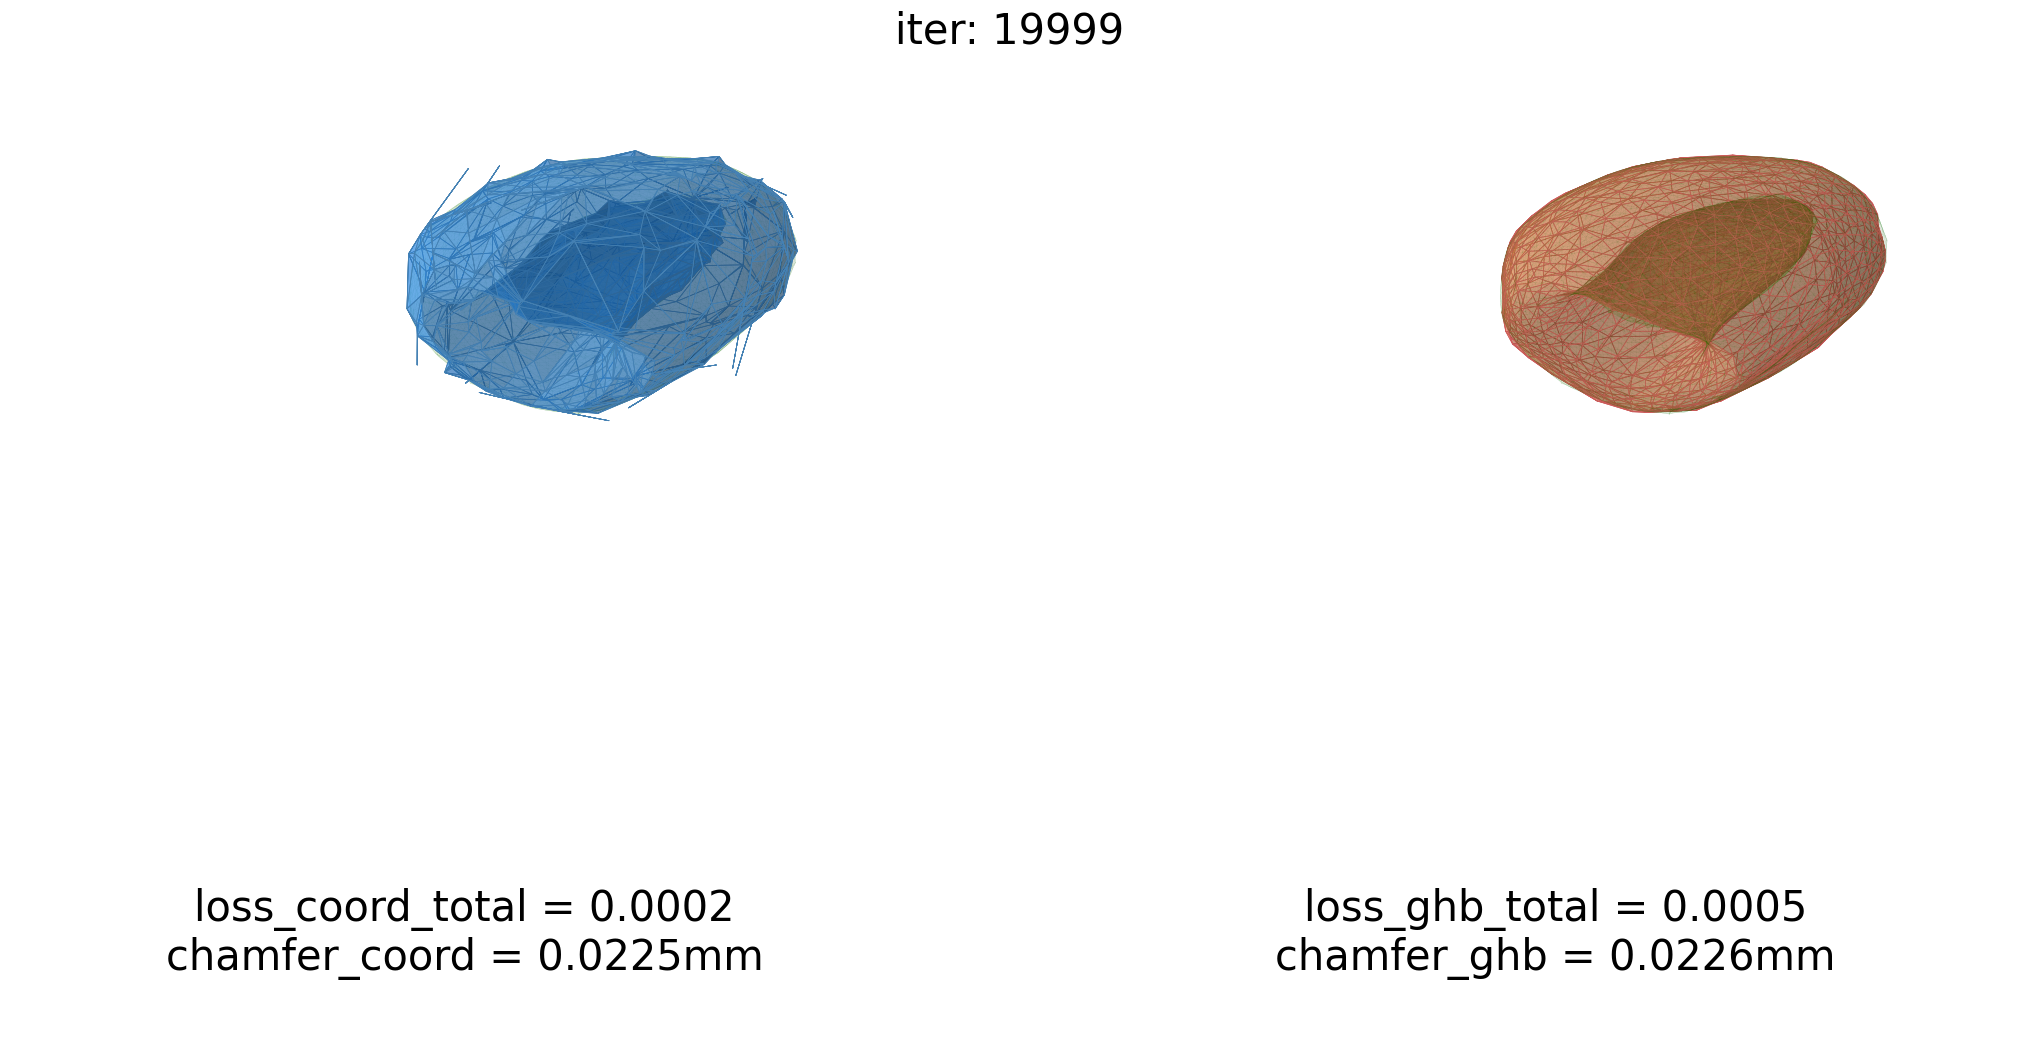

In [ ]:
def plot_save_convergence(i, target_mesh, current_mesh_coord, current_mesh_ghb, loss_coord, loss_ghb, chamfer_coord, chamfer_ghb):
    # plt to render the mesh
    vertices = target_mesh.verts_packed().detach().cpu().numpy()
    T = target_mesh.faces_packed().detach().cpu().numpy()

    fig = plt.figure(figsize=(20, 10))

    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    fig.tight_layout(pad=0)
    fig.suptitle('iter: %d' % i, fontsize=30)

    ax = fig.add_subplot(121, projection='3d')
    limit = 0.5
    ax.set_xlim(-limit,limit)
    ax.set_ylim(-limit,limit)
    ax.set_zlim(-limit,limit)

    ax.view_init(-10, -10)
    ax.grid(False)
    ax.axis('off')

    title = 'loss_coord_total = %.4f' % (loss_coord)+ '\n'+ 'chamfer_coord = %.4f' % (chamfer_coord*100)+ 'mm'+'\n'
    ax.set_title(title, fontsize=30, y=-0.1)

    ax.plot_trisurf(vertices[:,0], vertices[:,1], vertices[:,2], triangles = T, edgecolor='green', linewidth=0.01, alpha=0.05, color='yellowgreen')

    
    vertices_coord = current_mesh_coord.verts_packed().detach().cpu().numpy()
    T_coord = current_mesh_coord.faces_packed().detach().cpu().numpy()
    ax.plot_trisurf(vertices_coord[:,0], vertices_coord[:,1], vertices_coord[:,2], triangles = T_coord, edgecolor='steelblue', linewidth=0.5, alpha=0.4, color='dodgerblue')


    ax2 = fig.add_subplot(122, projection='3d')

    ax2.set_xlim(-limit,limit)
    ax2.set_ylim(-limit,limit)
    ax2.set_zlim(-limit,limit)

    ax2.view_init(-10,-10)

    ax2.grid(False)
    ax2.axis('off')

    

    title2 = 'loss_ghb_total = %.4f' % (loss_ghb)+ '\n'+ 'chamfer_ghb = %.4f' % (chamfer_ghb*100)+ 'mm'+ '\n'
    ax2.set_title(title2, fontsize=30, y=-0.1)
    # ax2.set_title('iter: %d' % i, y=-1, fontsize=15)

    ax2.plot_trisurf(vertices[:,0], vertices[:,1], vertices[:,2], triangles = T, edgecolor='green', linewidth=0.01, alpha=0.05, color='yellowgreen')

    vertices_ghb = current_mesh_ghb.verts_packed().detach().cpu().numpy()
    T_ghb = current_mesh_ghb.faces_packed().detach().cpu().numpy()
    ax2.plot_trisurf(vertices_ghb[:,0], vertices_ghb[:,1], vertices_ghb[:,2], triangles = T_ghb, edgecolor='indianred', linewidth=0.5, alpha=0.4, color='coral')

    # plt.show()
    plt.savefig('convergence_data/iter_%d.png' % i, bbox_inches='tight')

plot_save_convergence(i, mesh_gt_lv, current_mesh_coord, current_mesh_ghb, loss_coord.item(), loss_ghb.item(), loss_mesh_coord['loss_p0'].item(), loss_mesh_ghb['loss_p0'].item())

In [ ]:
plt.plot(Loss_occupancy_list)

NameError: name 'Loss_occupancy_list' is not defined

In [ ]:
pl = pv.Plotter(notebook=True)
# trimesh_gt_lv = trimesh.Trimesh(mesh_gt_lv.verts_packed().detach().cpu().numpy(), mesh_gt_lv.faces_packed().detach().cpu().numpy())
# trimesh_gt_lv = pv.wrap(trimesh_gt_lv)
# pl.add_mesh(trimesh_gt_lv, color='lightgreen', opacity=0.1)

current_lv_mesh = paraheart.rendering()
trimesh_current_lv = trimesh.Trimesh(current_lv_mesh.verts_packed().detach().cpu().numpy(), current_lv_mesh.faces_packed().detach().cpu().numpy())
trimesh_current_lv = pv.wrap(trimesh_current_lv)
pl.add_mesh(trimesh_current_lv, color='lightblue', opacity=0.2, show_edges=True, edge_color='blue', line_width=1, edge_opacity=0.2)

pl.add_points(points_lv.detach().cpu().numpy(), color='green', point_size=4, 
              render_points_as_spheres=True, opacity=0.5)
pl.show()
pl.clear()
pl.close()